# Tanzania Waterpumps
Problem:

Application:

Extension:

## Imports, Installs, and Initialization

In [1]:
pip install -i https://test.pypi.org/simple/ walkabout

Looking in indexes: https://test.pypi.org/simple/
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install eli5

  Using cached https://files.pythonhosted.org/packages/ee/2b/246db9e1c2d6f38e999daf0c4d5e54f36fbd0b937ffb13a34d32c2139403/eli5-0.8.2-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install category_encoders

  Using cached https://files.pythonhosted.org/packages/6e/a1/f7a22f144f33be78afeb06bfa78478e8284a64263a3c09b1ef54e673841e/category_encoders-2.0.0-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install xgboost

  Using cached https://files.pythonhosted.org/packages/5e/49/b95c037b717b4ceadc76b6e164603471225c27052d1611d5a2e832757945/xgboost-0.90-py2.py3-none-win_amd64.whl
Note: you may need to restart the kernel to use updated packages.


In [1]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import walkabout as wa
from eli5.sklearn import PermutationImportance
from eli5 import show_weights
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

In [2]:
# Make sure we can see all columns
pd.set_option('display.max_columns', 100)

def reset():
    #Create a function to quickly and easily reset our data
    
    # Read in all CSV's
    X_train = pd.read_csv('https://raw.githubusercontent.com/bundickm/Kaggle_Water_Pump_Competition/master/train_features.csv')
    X_test = pd.read_csv('https://raw.githubusercontent.com/bundickm/Kaggle_Water_Pump_Competition/master/test_features.csv')
    y_train = pd.read_csv('https://raw.githubusercontent.com/bundickm/Kaggle_Water_Pump_Competition/master/train_labels.csv')

    # Split X_train to training and validation
    return train_test_split(X_train, y_train, random_state=42, test_size=.2)


X_train, X_val, y_train, y_val = reset()

## Fast First Models

We want to begin by understanding what our target looks like. This will set a lower bound on how well we are doing. From the value counts below, we immediately know our simplest baseline should be at least 54%. Why? Because the simplest baseline for a classification problem is to simply guess the majority classifier for all rows.

In [3]:
y_train['status_group'].value_counts(normalize=True)

functional                 0.542971
non functional             0.384091
functional needs repair    0.072938
Name: status_group, dtype: float64

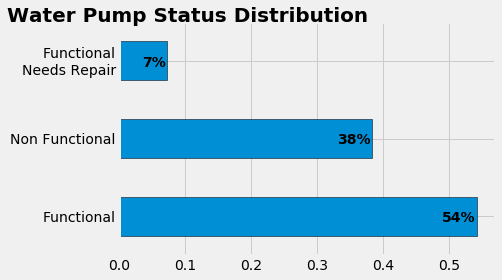

In [4]:
temp = y_train.copy()
temp = temp.replace({'functional needs repair':'Functional\nNeeds Repair',
                    'non functional':'Non Functional',
                    'functional':'Functional'})
temp = temp['status_group'].value_counts(normalize=True)

plt.style.use('fivethirtyeight')
ax = temp.plot.barh(edgecolor='black')

ax.text(x=-.17,y=2.5,s='Water Pump Status Distribution', 
        fontsize=20, fontweight='bold')
ax.text(x=.49,y=-.07,s='54%', fontsize=14, fontweight='bold')
ax.text(x=.33,y=.93,s='38%', fontsize=14, fontweight='bold')
ax.text(x=.035,y=1.93,s='7%', fontsize=14, fontweight='bold')

plt.show()

Next we are looking to build a lazy/simple model that does better than chance without much effort. This will give us starting point and a score to base the worth of our future efforts off of.

In [5]:
# Encode our categoricals
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

In [6]:
# Random Forest Classifier with no feature engineering (except encoding) and no hyperparameter tuning
forest = RandomForestClassifier(n_jobs=-1, random_state=42)

# Using randomized search cv isn't necessary at this stage but using it to have
# a working option later when I really care about hyperparameter optimization
param_distributions = {'n_estimators':[200],
                       'max_depth':[20]}

search = RandomizedSearchCV(forest, param_distributions=param_distributions,
                            scoring='accuracy', n_iter=1, n_jobs=-1, cv=5,
                            verbose=10, return_train_score=True, random_state=42)
search.fit(X_train, y_train['status_group'])

print('Training Accuracy Score:',search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   28.8s remaining:   43.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   29.8s remaining:   19.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.1s finished


Training Accuracy Score: 0.8085437710437711


In [7]:
# Solid score but I may have misleading results, need to test on the validation set as well
best = search.best_estimator_
X_val = encoder.transform(X_val)
y_pred = best.predict(X_val)
print('Validation Set Accuracy Score:', accuracy_score(y_val['status_group'], y_pred))

Validation Set Accuracy Score: 0.8111952861952862


Now that we have our baseline, we can begin a full exploration of the data and hopefully engineer additional features to improve the score. 

# Exploratory Data Analysis

Before resetting our data for EDA, we are going to pull feature importances using eli5. This gives us insight into what features were important to get us to 81% accuracy. Once we know what features have the greatest weight, we know which features to start our data engineering efforts with and which ones are likely a waste of time.

In [8]:
permuter = PermutationImportance(best, scoring='accuracy', cv='prefit', 
                                 n_iter=3, random_state=42)

permuter.fit(X_val, y_val['status_group'])

feature_names = X_val.columns.tolist()
show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0412 ± 0.0040,quantity
0.0267 ± 0.0005,quantity_group
0.0157 ± 0.0014,construction_year
0.0126 ± 0.0020,waterpoint_type
0.0123 ± 0.0022,extraction_type_class
0.0094 ± 0.0012,longitude
0.0090 ± 0.0006,amount_tsh
0.0088 ± 0.0009,population
0.0060 ± 0.0018,latitude
0.0033 ± 0.0023,funder


In [9]:
# Reset our data for EDA so categorical variables are no longer encoded as numeric
X_train, X_val, y_train, y_val = reset()

Walkabout (aliased as `wa`) is a library I wrote to speed up EDA and will be used below

In [10]:
# Take a look at all the basic stuff first
wa.report.rundown(X_train, include_types_uniques=False)

DataFrame Shape
Rows: 47520    Columns: 40

Column                     mean          std       min          25%         50%          75%          max
-----------------  ------------  -----------  --------  -----------  ----------  -----------  -----------
id                 37114.5       21445.8        0       18555.8      37038       55666.2       74247
amount_tsh           322.048      3200.62       0           0            0          20        350000
gps_height           668.745       692.972    -63           0          370        1320          2770
longitude             34.0913        6.5384     0          33.0843      34.9117     37.1806       40.3452
latitude              -5.705         2.9435   -11.6494     -8.53247     -5.0177     -3.32646      -2e-08
num_private            0.504566     13.2538     0           0            0           0          1776
region_code           15.3265       17.6188     1           5           12          17            99
district_code          5.639

In [11]:
wa.report.type_and_unique(X_train, unq_limit=5)

Column                 Type       nUnique  Unique Values
---------------------  -------  ---------  -------------------------------------------------------------------------------------
id                     int64        47520  454, 510, 14146, 47410, 1288...
amount_tsh             float64         96  50.0, 0.0, 300.0, 10.0, 8000.0...
date_recorded          object         351  2013-02-27, 2011-03-17, 2011-07-10, 2011-04-12, 2011-04-05...
funder                 object        1698  Dmdd, Cmsr, Kkkt, nan, Ki...
gps_height             int64         2401  2092, 0, 1023, 298, 1141...
installer              object        1923  DMDD, Gove, KKKT, nan, Ki...
longitude              float64      46043  35.42602046, 35.51007372, 32.49986613, 34.06048376, 37.03268998...
latitude               float64      46044  -4.22744596, -5.7245550000000005, -9.08122219, -8.83020763, -6.04078736...
wpt_name               object       30742  Narmo, Lukali, Mahakama, Shule Ya Msingi Chosi A, Kwa Mjowe...
num_priv

In [12]:
# With nulls, one correlation pair that is extremely correlated, and two pairs that are high. Indicates MAR
wa.report.high_correlations(X_train.isnull())

Feature 1    Feature 2       Value
-----------  -----------  --------
funder       installer    0.980983
funder       permit       0.708053
installer    permit       0.705098

Threshold: 0.7


## Cleaning To-Do's
- Handful of columns that have nulls
- A few columns with possible placeholder nulls
- Three gps related coordinates that we will want to verify are within the bounds of Tanzania
- `construction_year`, `amount_tsh`, `population`, and `num_private` look to have odd distributions we wouldn't expect
- 3 interrelated feature pairs with high correlation on their missing values
- Many features share similar names and looking at the labels of these features reveals they represent the same data
- Convert all categorical features to lowercase to consolidate values like 'None' and 'none'
- Date recorded should be in datetime format, not string

### Drop Features
Before we spend time cleaning features we will drop some that aren't necessary because of duplication or because they simply add no value. I will be looking at the feature importances above, which features better explain the data, and a bit of intuition to remove features. If our model underperforms or we have additional time, we can look at adding features back in but this allows us to prioritize our effort.

In [13]:
# Report for showing labels that are extreme minority or majority
wa.report.assess_categoricals(X_train, high_thresh=.75)

Feature                  # Below Thresh    nUnique  High Thresh Violators
---------------------  ----------------  ---------  -----------------------
date_recorded                       351        351
funder                             1696       1698
installer                          1922       1923
wpt_name                          30741      30742
basin                                 1          9
subvillage                        17232      17232
region                               13         21
lga                                 125        125
ward                               2076       2076
public_meeting                        0          2  True
recorded_by                           0          1  GeoData Consultants Ltd
scheme_management                     8         12
scheme_name                        2541       2541
permit                                0          2
extraction_type                      13         18
extraction_type_group                 8         13
ext

In [14]:
# Use value counts to inspect label distributions before dropping features
X_train['source_class'].value_counts(normalize=True, dropna=False)

groundwater    0.770770
surface        0.224306
unknown        0.004924
Name: source_class, dtype: float64

In [15]:
# The drop list. We'll be putting all the feature cleaning and engineering in one spot below, 
# so for now we will just call this as necessary
drop_features = ['id', 'wpt_name', 'source', 'source_type', 'recorded_by', 'management', 'management_group',
                 'recorded_by', 'public_meeting', 'region', 'district_code', 'extraction_type_group',
                 'extraction_type', 'source', 'source_type', 'subvillage', 'extraction_type',
                 'extraction_type_group', 'permit', 'num_private', 'scheme_management']

# We've dropped 16 of the original 40 features
X_train.drop(drop_features, axis=1).shape

(47520, 24)

### Imputation
Columns with nulls
- `funder`
- `installer`
- `subvillage` - Dropped
- `public_meeting` - Dropped
- `scheme_name` 
- `scheme_management` - Dropped
- `permit` - Dropped

4 out of the 7 were dropped saving a lot of upfront time and effort. Thanks to dropped features, we also only need to fill these 3 features in order to address the remaining features that were marked as having possible placeholders.

We saw above `funder` and `installer` have a high correlation on their missing values so we will deal with them together. Looking more into the two features, we see a correlation of the funder also being the installer (we may be able to drop one of them later because of this). Knowing this we can fill some of the nulls by using the other column when it is not null. From there we can fill the rest with `none` since it does not appear that the labels follow a pattern we can fill off of for either feature and this allows us to consolidate on a pre-existing label.

In [16]:
X_train[['funder', 'installer']].head()

,funder,installer
3607,Dmdd,DMDD
50870,Cmsr,Gove
20413,Kkkt,KKKT
52806,NaN,NaN
50091,Ki,Ki


In [17]:
# Throw all of the cleaning and feature engineering into functions for later
# consolidation as well as easy testing.

def impute_funder_installer(df):
    # Fill `funder` and then `installer` based off the other column.
    # We could leave off the conditional for not null in both statements,
    # since it would just fill NaN with NaN but I prefer the explicit case.
    df = df.copy()
    
    df.loc[((df['funder'].isnull()) & (df['installer'].notnull())), 
            'funder'] = df['installer']

    df.loc[((df['funder'].notnull()) & (df['installer'].isnull())), 
            'installer'] = df['funder']

    # Fill nulls with `none`
    df[['funder', 'installer']] = df[['funder', 'installer']].fillna('none')
    
    return df

We see `scheme_name` has almost half of its values as null, with the next most common label being just above 1%. In this case it may be better to turn this feature into a binary flag.

In [18]:
X_train['scheme_name'].value_counts(dropna=False, normalize=True)[:5]

NaN              0.473969
K                0.011427
None             0.010795
Borehole         0.009133
Chalinze wate    0.006734
Name: scheme_name, dtype: float64

In [19]:
def create_has_scheme(df):
    df = df.copy()
    
    # Fill and consolidate NaN with `None`
    df['scheme_name'] = df['scheme_name'].fillna('none')
    df['scheme_name'] = df['scheme_name'].str.lower()

    # Create binary feature and add `scheme_name` to drop features
    df['has_scheme'] = (df['scheme_name'] != 'none')
    
    return df

### GPS Issues
When we graph latitude and longitude we see the `0`'s we saw before are in fact placeholders and they cause the graphed points to not properly depict the shape of Tanzania. To address this we'll replace the `0`'s with the mean value for whichever `region_code` they are apart of.

Looking at `gps_height` a bit closer we see all heights are within a range we might expect for [Tanzania](https://en.wikipedia.org/wiki/Geography_of_Tanzania#Statistics) and it's elevation variance. Since we don't have anything showing up as a red flag, we'll leave it be.

![](https://www.tanzania-experience.com/wp-content/uploads/2019/01/tanzania-map.png)

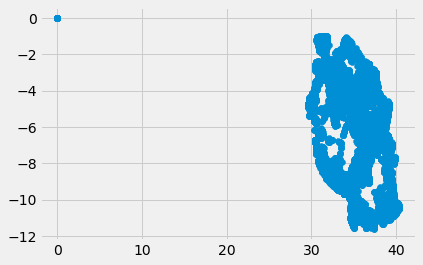

In [20]:
plt.scatter(X_train['longitude'], X_train['latitude']);

In [21]:
def lat_long_correction(df):
    df = df.copy()
    
    # latitude has a floating point precision error so we are selecting via the `>` comparison operator
    df.loc[df['longitude'] == 0, 'longitude'] = df.groupby(
                                 'region_code')['longitude'].transform('mean')
    df.loc[df['latitude'] > -.001, 'latitude'] = df.groupby(
                                 'region_code')['latitude'].transform('mean')
    
    return df

### Distribution Issues

A couple of features had funny looking distribution errors that we need to investigate and possibly correct. We can start with the easy one, `num_private`, which was added to the dropped features above due to low feature importance and being 99% 0.

Next we have `construction_year` with about a third of all values being 0. Looking at the distribution of `construction_year` without the 0's we see the mean and median are rather close at 1997 and 2000. With the measures of centrality being so close together, filling with mean or median will give very similar results. Once last consideration is `date_recorded` because we don't want a well's `construction_year` to be after it is inspected. Luckily, 2004 is the first inspection year so no issues there.

In [22]:
X_train['construction_year'].value_counts(dropna=False, normalize=True)[:5]

0       0.347285
2010    0.044886
2008    0.044697
2009    0.042656
2000    0.035396
Name: construction_year, dtype: float64

In [23]:
X_train[X_train['construction_year'] > 0][['construction_year']].describe()[1:6:4]

,construction_year
mean,1996.819293
50%,2000.000000


In [24]:
X_train['date_recorded'].min()

'2004-01-07'

In [25]:
X_train[X_train['construction_year'] > 0]['construction_year'].median()

2000.0

`amount_tsh` stands for total static head, or the total vertical distance that a pump raises water. Given that 70% are 0 we need to find out if it is reasonable that our pumps would not raise water. Some scenarios where that may be true:

- Water is being pumped horizontally (possibly from a body of water to a more convenient location)
- Water is not being pumped at all (broken pump)
- Water is being retrieved from a higher elevation and negative elevation change is not recorded or "pump" is gravity fed

Scenario 3 requires some assumptions that we can't answer since I can't ask for more information on how the data is collected. So that leaves scenarios 1 and 2, and the question of whether broken pumps plus horizontal movement could account for so many wells with a static head of 0. The answer is a plausible yes since a vast majority of the pumps have a gps height greater than or equal to 0. 

This is a perfect reason why subject matter expertise is so important, because we are making decisions that may be ill informed. We can test different handlings of `amount_tsh` and its impact on the ending accuracy through trial and error but that requires a great deal of time and potential computing power.

On the opposite end of the spectrum, we also have some major outliers with a max `amount_tsh` of 350,000 but 75% of all values below 20. Using walkabout we can create a mask of outliers based on the interquartile range (IQR) and see almost a fifth of values are considered outliers. This is a biased due to so many pumps at 0, so we will filter out the 0's and find we have a more reasonable 4% of values are outliers. We will reassign these outliers with the mean of `amount_tsh` sans the 0's.

In [26]:
X_train['amount_tsh'].describe()

count     47520.000000
mean        322.047573
std        3200.623244
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

In [27]:
wa.support.outlier_mask(X_train[X_train['amount_tsh'] > 0]['amount_tsh']).value_counts()

False    12172
True      2017
Name: amount_tsh, dtype: int64

In [28]:
X_train[X_train['amount_tsh'] > 0]['amount_tsh'].mean()

1078.5609028120373

Last but not least, we have `population` with 36% of values being 0, and another 12% at 1. This seems extremely unlikely and would be another great place to have subject matter expertise or knowledge about the data collection methods. Since we don't have those resources we will set the 0 populations to be the mean population of that region.

In [29]:
X_train[X_train['population'] > 1]['population'].describe()

count    24817.000000
mean       343.535842
std        609.666343
min          2.000000
25%        100.000000
50%        200.000000
75%        380.000000
max      30500.000000
Name: population, dtype: float64

In [30]:
def correct_distribution_issues(df):
    df = df.copy()
    
    # construction year
    construct_med = df[df['construction_year'] > 0]['construction_year'].median()
    df.loc[df['construction_year'] == 0, 'construction_year'] = construct_med
    
    # amount_tsh
    mask = (df['amount_tsh'] > 1500)
    tsh_mean = df[df['amount_tsh'] > 0]['amount_tsh'].mean()
    df.loc[mask, 'amount_tsh'] = tsh_mean
    
    # population
    df.loc[df['population'] == 0, 'population'] = df.groupby(
                                 'region_code')['population'].transform('mean')
    
    return df

In [31]:
def to_lowercase(df):
    df = df.copy()
    
    cols = df.select_dtypes(include='object').columns
    for col in cols:
        df[col] = df[col].str.lower()
    
    return df

With all of our cleaning to-do's complete, we simply consolidate out work and apply it to X_train so we can continue with our EDA. We aren't including drop features here since we will likely be adding more to it after feature engingeering and testing our model.

In [32]:
def cleaning(df):
    df = df.copy()
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df = to_lowercase(df)
    df = impute_funder_installer(df)
    df = create_has_scheme(df)
    df = lat_long_correction(df)
    df = correct_distribution_issues(df)
    
    return df

X_train = cleaning(X_train)

In [33]:
drop_features = ['id', 'wpt_name', 'source', 'source_type', 'recorded_by', 'management', 'management_group',
                 'recorded_by', 'public_meeting', 'region', 'district_code', 'extraction_type_group',
                 'extraction_type', 'source', 'source_type', 'subvillage', 'extraction_type',
                 'extraction_type_group', 'permit', 'num_private', 'scheme_management', 'scheme_name']

## EDA Continued

In [34]:
df = X_train.merge(y_train)

Looking at bivariate distributions, we see some of the overlapping features that we considered dropping before but didn't have near identical distributions and therefore don't add much predictive power. At this point we can add a few more features to our drop list.

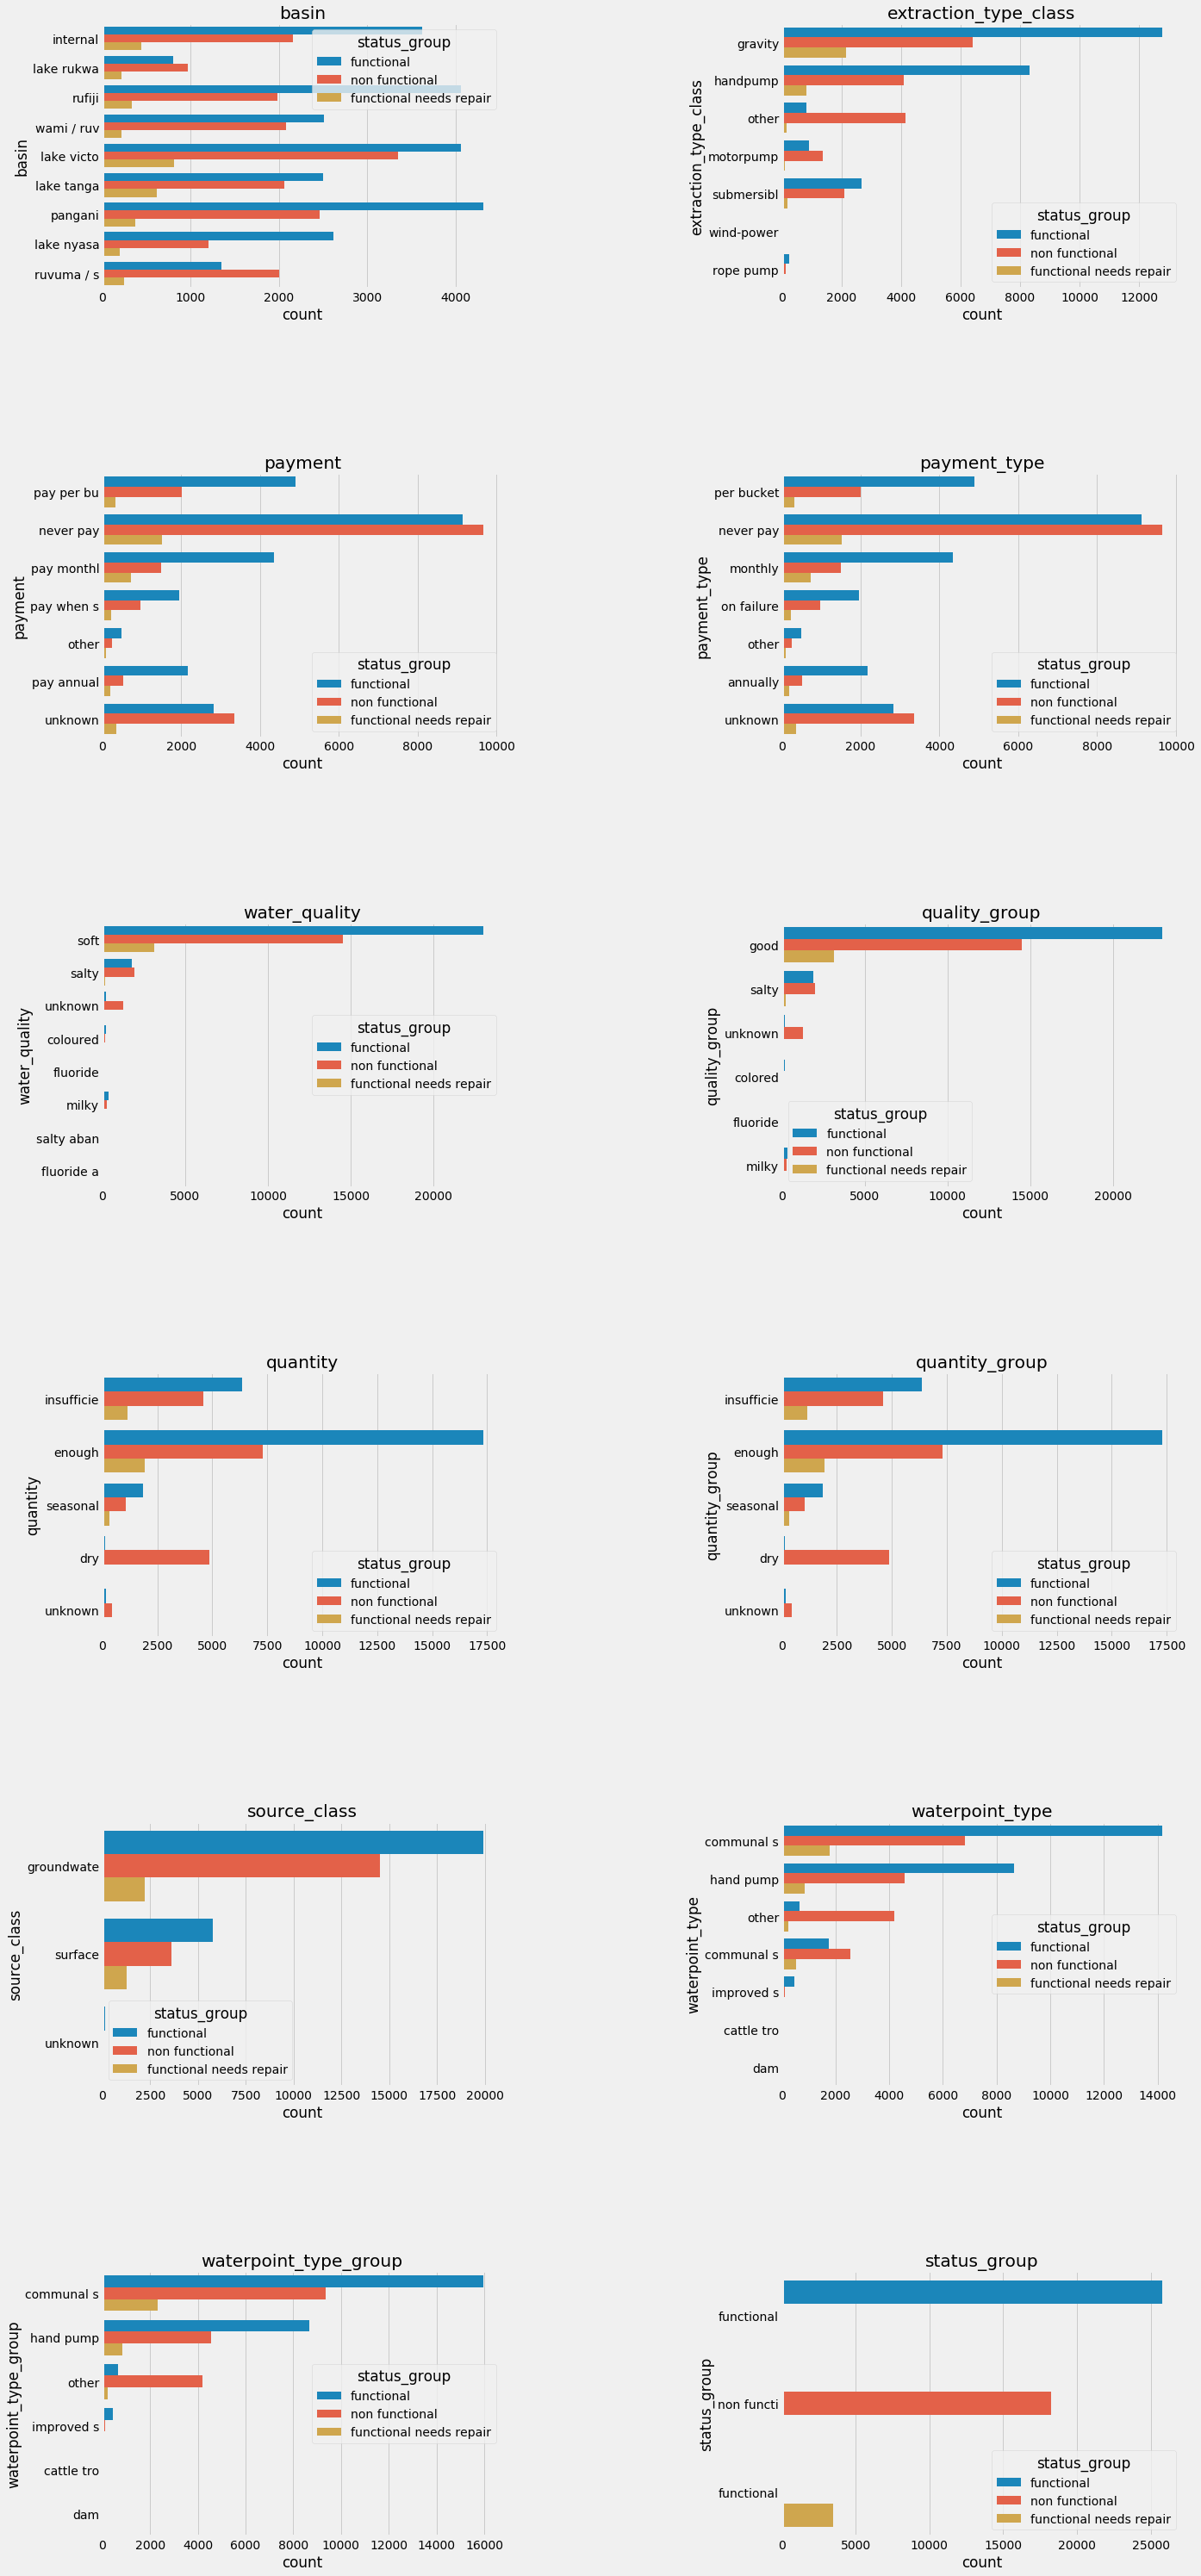

In [35]:
# Quick and dirty way to look at bivariate categorical distributions without
# high ordinality features creating unreadable graphs
drop2 = []
for col in df.drop(drop_features, axis=1):
    if df[col].nunique() > 10:
        drop2.append(col)
        
wa.plot.bivariate_categorical_distribution(df.drop(drop_features, axis=1).drop(drop2, axis=1),
                                           'status_group', cols=2, hspace=.7, wspace=.7, 
                                           figsize=(20,50))

In [36]:
drop_features = ['id', 'wpt_name', 'source', 'source_type', 'recorded_by', 'management', 'management_group',
                 'recorded_by', 'public_meeting', 'region', 'district_code', 'extraction_type_group',
                 'extraction_type', 'source', 'source_type', 'subvillage', 'extraction_type',
                 'extraction_type_group', 'permit', 'num_private', 'scheme_management', 'scheme_name', 
                 'payment_type', 'water_quality', 'quantity_group', 'waterpoint_type_group']

# Feature Engineering
Now that we have begun to understand our data, we can attempt to engineer new features to improve our model accuracy. Before we do do that though, we need to check that our cleaning didn't make things worse. 

After running our model with cleaning and dropped features we haven't really moved our score. This is within what we might expect, and likely indicates some of the features have an outsized effect on accuracy or that many of the features were duplicate enformation.

As we move forward, we will show many engineered features some that will not be included in the end result. Intuition and some programming tricks will help us decide what features to engineer, but trial and error of running the model will determine what stays in the end. Scroll ahead to "Model Testing" to see the final features.

In [37]:
X_train, X_val, y_train, y_val = reset()

X_train = cleaning(X_train)
X_train = X_train.drop(drop_features, axis=1).drop('date_recorded', axis=1)

# Encode our categoricals
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

# Random Forest Classifier with no feature engineering (except encoding) and no hyperparameter tuning
forest = RandomForestClassifier(n_jobs=-1, random_state=42)

# Using randomized search cv isn't necessary at this stage but using it to have
# a working option later when I really care about hyperparameter optimization
param_distributions = {'n_estimators':[200],
                       'max_depth':[20]}

search = RandomizedSearchCV(forest, param_distributions=param_distributions,
                            scoring='accuracy', n_iter=1, n_jobs=-1, cv=5,
                            verbose=10, return_train_score=True, random_state=42)
search.fit(X_train, y_train['status_group'])

print('Training Accuracy Score:', search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.3s remaining:   24.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.4s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.5s finished


Training Accuracy Score: 0.8054924242424243


In [38]:
# Solid score but I may have misleading results, need to test on the validation set as well
best = search.best_estimator_

X_val = cleaning(X_val)
X_val = X_val.drop(drop_features, axis=1).drop('date_recorded', axis=1)
X_val = encoder.fit_transform(X_val)

y_pred = best.predict(X_val)
print('Validation Set Accuracy Score:', accuracy_score(y_val['status_group'], y_pred))

Validation Set Accuracy Score: 0.810016835016835


In [39]:
permuter = PermutationImportance(best, scoring='accuracy', cv='prefit', 
                                 n_iter=3, random_state=42)

permuter.fit(X_val, y_val['status_group'])

feature_names = X_val.columns.tolist()
show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.1049 ± 0.0050,quantity
0.0530 ± 0.0012,extraction_type_class
0.0374 ± 0.0004,waterpoint_type
0.0219 ± 0.0039,construction_year
0.0185 ± 0.0033,longitude
0.0156 ± 0.0018,amount_tsh
0.0128 ± 0.0014,latitude
0.0116 ± 0.0033,population
0.0088 ± 0.0006,payment
0.0072 ± 0.0001,lga


```python
current_year = datetime.now().year
df['age'] = current_year - df['construction_year']
```

```python
df['lat+lon'] = ((df['latitude']+90)*180)+df['longitude']
```

```python
df['water_per_person'] = df['amount_tsh']/df['population']
df.loc[df['water_per_person'] == np.inf,'water_per_person'] = np.NaN
df['water_per_person'] = test.fillna(0)
```

```python
df['inspect_wait'] = df['date_recorded'].dt.year - df['construction_year']
```

```python
def seasons(months): #Ended up being worse
  #See if we can boost the month signal by consolidating to seasons
  #https://www.wildland.com/destinations/africa/tanzania/seasonsclimate.aspx
  seasons = months.copy()
  
  seasons.loc[(months < 3) | (months == 12)] = 'Hot Dry' #December to February
  seasons.loc[months == 3] = 'Intermittent Rains' #March
  seasons.loc[(months == 4) | (months == 5)] = 'Heavy Rains' #April and May
  seasons.loc[(months > 5) & (months < 11)] = 'Cool Dry' #June to October
  seasons.loc[months == 11] = 'Short Rains' #November
  
  return seasons
```

In [48]:
# Quick and dirty trick facilitated by walkabout to check out all feature interaction pairs
X_train, X_val, y_train, y_val = reset()

X_train = cleaning(df)
X_train = X_train.drop(drop_features, axis=1).drop(['date_recorded', 'has_scheme'], axis=1)
cat_cols = [col for col in X_train.select_dtypes(include='object')]
X_train = X_train.drop(cat_cols, axis=1)
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

interactions = wa.report.interaction_feature_importance(X_train, y_train['status_group'], model='clas')
interactions.head(10)

,Score
Feature,
construction_year^2,1217.78
amount_tsh * longitude,685.177
amount_tsh * construction_year,679.897
amount_tsh * latitude,646.591
amount_tsh * gps_height,630.6
amount_tsh^2,493.774
gps_height^2,452.837
amount_tsh * region_code,409.847
longitude * construction_year,393.413


In [104]:
def feature_engineer(df):
    df = df.copy()
    
    drop_features = ['id', 'wpt_name', 'source', 'source_type', 'recorded_by', 'management', 'management_group',
                 'recorded_by', 'public_meeting', 'region', 'district_code', 'extraction_type_group',
                 'extraction_type', 'source', 'source_type', 'subvillage', 'extraction_type',
                 'extraction_type_group', 'permit', 'num_private', 'scheme_management', 'scheme_name', 
                 'payment_type', 'water_quality', 'quantity_group', 'waterpoint_type_group', 'date_recorded',
                 'has_scheme', 'region_code', 'basin']
    
    df = cleaning(df)
    
    df['inspect_wait'] = df['date_recorded'].dt.year - df['construction_year']
    
    df = df.drop(drop_features, axis=1)

    return df

In [105]:
X_train, X_val, y_train, y_val = reset()

X_train = feature_engineer(X_train)

# Encode our categoricals
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

forest = RandomForestClassifier(n_jobs=-1, random_state=42)

param_distributions = {'n_estimators':[200],
                       'max_depth':[20]}

search = RandomizedSearchCV(forest, param_distributions=param_distributions,
                            scoring='accuracy', n_iter=1, n_jobs=-1, cv=5,
                            verbose=10, return_train_score=True, random_state=42)
search.fit(X_train, y_train['status_group'])

print('Training Accuracy Score:', search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   22.3s remaining:   33.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   22.6s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.7s finished


Training Accuracy Score: 0.8034511784511784


In [106]:
best = search.best_estimator_
X_val = feature_engineer(X_val)
X_val = encoder.transform(X_val)
y_pred = best.predict(X_val)
print('Validation Set Accuracy Score:', accuracy_score(y_val['status_group'], y_pred))

permuter = PermutationImportance(best, scoring='accuracy', cv='prefit', 
                                 n_iter=3, random_state=42)
permuter.fit(X_val, y_val['status_group'])
feature_names = X_val.columns.tolist()
show_weights(permuter, top=None, feature_names=feature_names)

Validation Set Accuracy Score: 0.8088383838383838


Weight,Feature
0.1041 ± 0.0032,quantity
0.0486 ± 0.0010,extraction_type_class
0.0418 ± 0.0057,waterpoint_type
0.0184 ± 0.0008,longitude
0.0181 ± 0.0008,amount_tsh
0.0159 ± 0.0033,latitude
0.0123 ± 0.0017,population
0.0095 ± 0.0003,payment
0.0075 ± 0.0011,lga
0.0061 ± 0.0014,construction_year
